In [32]:
#exploration des donn√©es 

#import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import re

#chargement du DataFrame
csv_path = "DataFrame.csv"
df = pd.read_csv(csv_path, encoding="utf-8")

#affichage du nombre de lignes et de colonnes
print(f"Le fichier csv contient {df.shape[0]} lignes et {df.shape[1]} colonnes. \n")


#affichage des informations g√©n√©rales
print("--> Informations generales sur le DataFrame : \n")
df.info()

#aper√ßu des 1eres lignes
print("\n --> Apercu des donn√©es")
print(df.head())

#comptage des donn√©es manquantes
def compter_manquants(col):
    return ((col.isna()) | (col == "") | (col == "Non disponible")).sum()

#application √† chaque colonne
manquants = df.apply(compter_manquants)

#affichage des donn√©es manquantes
print("\nNombre de donn√©es manquantes par colonne (NaN, vide, ou 'Non disponible') :\n")
print(manquants.sort_values(ascending=False))

# Nettoyage de base
df['CVSS_score'] = pd.to_numeric(df['CVSS_score'], errors='coerce')
df['EPSS_score'] = pd.to_numeric(df['EPSS_score'], errors='coerce')
df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df['CWE'] = df['CWE'].fillna("Non class√©")
df['Editeur'] = df['Editeur'].fillna("Inconnu")
df['Produit'] = df['Produit'].fillna("Non sp√©cifi√©")


Le fichier csv contient 134909 lignes et 15 colonnes. 

--> Informations generales sur le DataFrame : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134909 entries, 0 to 134908
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID_ANSSI            134909 non-null  object 
 1   Titre_ANSSI         134909 non-null  object 
 2   Type                134909 non-null  object 
 3   Date_publication    134909 non-null  object 
 4   CVE_ID              134909 non-null  object 
 5   CVSS_score          38622 non-null   float64
 6   Base_Severity       134909 non-null  object 
 7   CWE                 134909 non-null  object 
 8   CWE_description     131629 non-null  object 
 9   EPSS_score          134648 non-null  float64
 10  Lien_bulletin       134909 non-null  object 
 11  Description         134909 non-null  object 
 12  Editeur             128357 non-null  object 
 13  Produit             131346 non

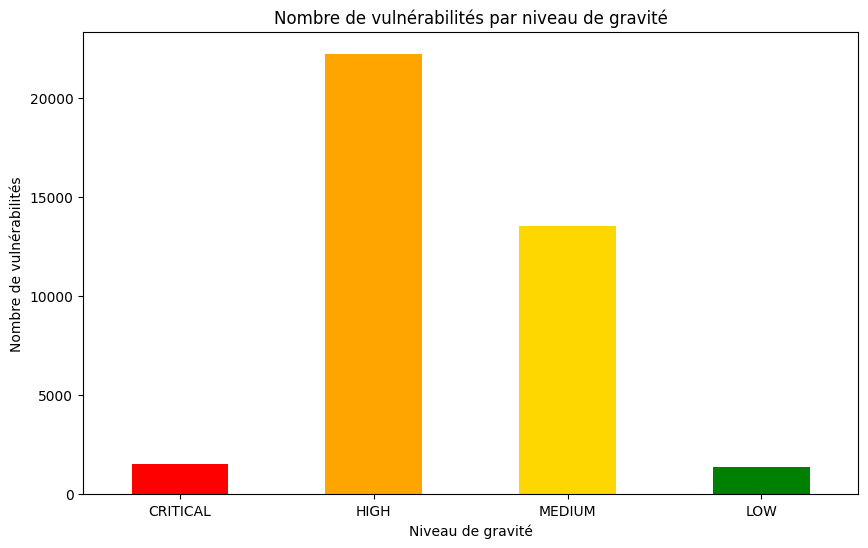

In [ ]:
# √âtape 5 ‚Äì Visualisation et Interpr√©tation des CVE enrichies

# Graphique 1.1 :  Histogramme des vuln√©rabilit√©s par niveau de gravit√© CVSS

# Ce graphique fournit fournit une vue d'ensemble claire de la r√©partition des vuln√©rabilit√©s selon leur gravit√© (bas√© sur le score CVSS)
# Cela permet notamment de visualiser la charge globale de s√©curit√© (ex. : forte proportion de vuln√©rabilit√©s critiques ou √©lev√©es)


df["Base_Severity"] = df["Base_Severity"].str.upper() #uniformiser en majuscules pour √©viter les doublons
df = df[df["Base_Severity"].notna() &(df["Base_Severity"] != "NON DISPONIBLE")] #suppp les valeurs manquantes ou "NON DISPONIBLE"
ordre = ["CRITICAL", "HIGH", "MEDIUM", "LOW"]
df["Base_Severity"] = pd.Categorical(df["Base_Severity"], categories=ordre, ordered=True)
counts = df["Base_Severity"].value_counts().sort_index()
couleurs = {
    "CRITICAL": "red",
    "HIGH": "orange",
    "MEDIUM": "gold",
    "LOW": "green"
}
color_list = [couleurs.get(sev, "gray") for sev in counts.index]

plt.figure(figsize=(10,6))
counts.plot(kind="bar", color=color_list)
plt.title("Nombre de vuln√©rabilit√©s par niveau de gravit√©")
plt.xlabel("Niveau de gravit√©")
plt.ylabel("Nombre de vuln√©rabilit√©s")
plt.xticks(rotation=0)
plt.show()

On remarque gr√¢ce √† ce graphique que : 
- La majorit√© des vuln√©rabilit√©s sont de niveau HIGH, avec environ 22 000 cas. Cette forte proportion de vuln√©rabilit√©s √©lev√©es indique qu‚Äôun grand nombre de failles pr√©sentes dans les syst√®mes peuvent avoir un impact s√©rieux si elles sont exploit√©es
- Le niveau MEDIUM suit avec environ 13 000 vuln√©rabilit√©s, ce qui reste significatif
- Les niveaux CRITICAL et LOW sont nettement moins repr√©sent√©s (environ 1 500 cas chacun)

Ce graphique met donc en √©vidence une forte concentration de failles √† impact √©lev√© (HIGH et MEDIUM), ce qui sugg√®re un besoin de vigilance renforc√©e.
De plus, m√™me si les vuln√©rabilit√©s critiques sont peu nombreuses, elles repr√©sentent un risque majeur et n√©cessitent une priorisation imm√©diate en mati√®re de correction.

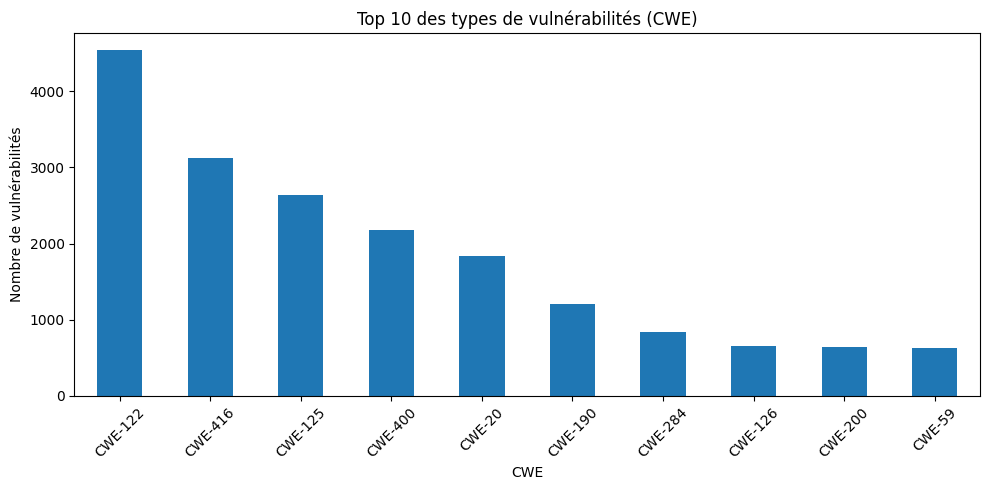

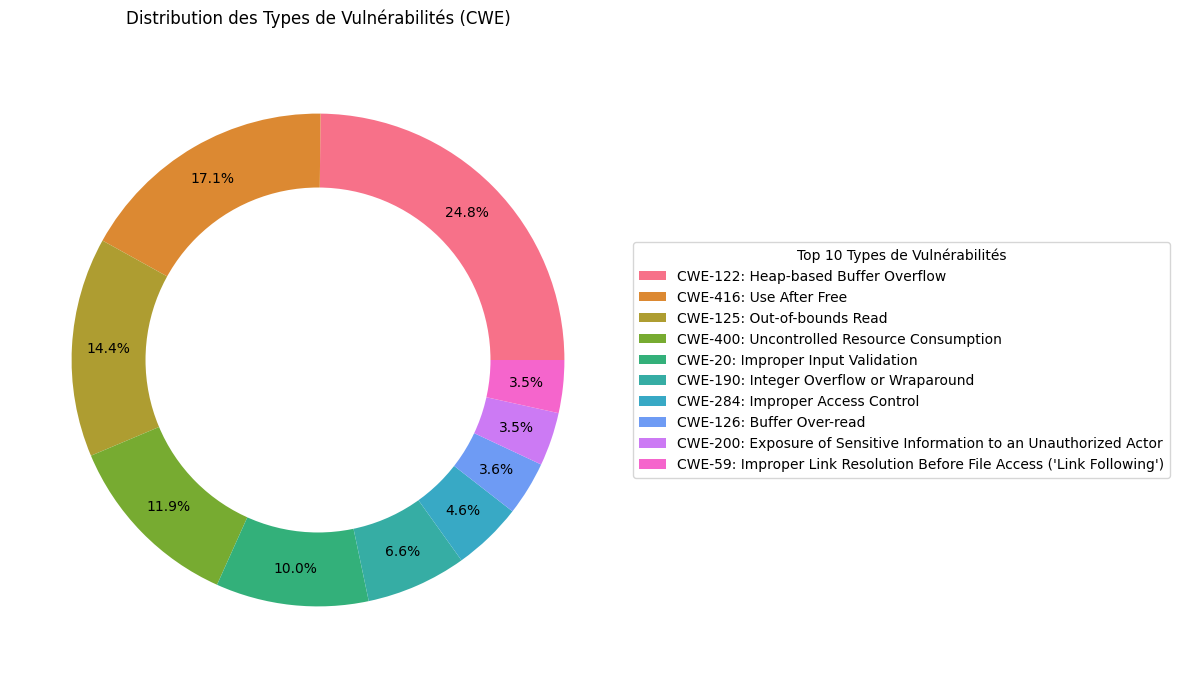

In [ ]:
# Graphique 2.1 : Top 10 des types vuln√©rabilit√©s les + fr√©quentes (CWE)

# Ce graphique permet d‚Äôidentifier les 10 types de vuln√©rabilit√©s les plus fr√©quemment rencontr√©es dans les alertes de s√©curit√©, afin de prioriser leur correction et leur d√©tection dans les syst√®mes

cwe_valides = df[df['CWE'].notna() & (df['CWE'] != "Non disponible")] # on filtre les CWE valides (diff√©rents de "Non disponible" et non nuls)
cwe_counts = cwe_valides['CWE'].value_counts().head(10) # on compte les 10 CWE les plus fr√©quents
plt.figure(figsize=(10, 5))
cwe_counts.plot(kind='bar')
plt.title("Top 10 des types de vuln√©rabilit√©s (CWE)")
plt.xlabel("CWE")
plt.ylabel("Nombre de vuln√©rabilit√©s")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Graphique 2.2 : Diagramme circulaire des types de vuln√©rabilit√©s (CWE)

# Ce graphique repr√©sente les m√™mes 10 CWE que dans l‚Äôhistogramme, mais ici en pourcentages du total. Chaque portion du cercle indique la part d‚Äôun type de vuln√©rabilit√©
# La l√©gende affiche √† la fois le code CWE et sa description, ce qui rend la visualisation plus explicite pour un public non technique

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
cwe_data = df[df['CWE'] != 'Non disponible']['CWE'].value_counts().head(10) # enlever les "Non disponible" et r√©cup le top 10 
colors = sns.color_palette('husl', n_colors=len(cwe_data)) # cr√©ation pie chart
patches, texts, autotexts = plt.pie(cwe_data.values, colors=colors, autopct='%1.1f%%', pctdistance=0.85)
centre_circle = plt.Circle((0,0), 0.70, fc='white') # ajouter un cercle au milieu pour cr√©er un diagram donut
plt.gca().add_artist(centre_circle)
cwe_desc = (df[df['CWE'].isin(cwe_data.index)].groupby('CWE')['CWE_description'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])) # r√©cup√©rer les descriptions associ√©es aux CWE
legend_labels = [f"{code}: {re.sub(rf'^{re.escape(code)}:?\s*', '', str(cwe_desc[code]))}" for code in cwe_data.index] # nettoyer et construire les labels combin√©s
plt.legend(patches, legend_labels,title="Top 10 Types de Vuln√©rabilit√©s", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Distribution des Types de Vuln√©rabilit√©s (CWE)', pad=20)
plt.show()

Ces deux graphiques mettent en √©vidence les types de vuln√©rabilit√©s (CWE) les plus fr√©quents recens√©s. On remarque que : 

- CWE-416 (Use After Free) est de loin la plus fr√©quente, avec pr√®s de 8000 cas. Cela indique qu'un grand nombre de logiciels manipulent mal la m√©moire apr√®s lib√©ration. CWE-416 repr√©sente √† lui seul pr√®s de 25 % des vuln√©rabilit√©s, ce qui confirme sa dominance en termes de volume et d‚Äôimportance.

- CWE-122 (Heap-Based Buffer Overflow) et CWE-125 (Out-of-Bounds Read) suivent, avec environ 4700 vuln√©rabilit√©s chacune. Ces deux vuln√©rabilit√©s sont li√©es √† des erreurs dans la gestion des tampons m√©moire et peuvent conduire √† des fuites d'information ou √† des corruptions de donn√©es.

- Sur les 10 premi√®res vuln√©rabilit√©s, la majorit√© (CWE-416, 122, 125, 476, 787, 190, 191) sont li√©es √† des erreurs de gestion de m√©moire : d√©r√©f√©rencement de pointeurs nuls, d√©passement de tampon, ou arithm√©tique non s√©curis√©e. Cela souligne que les erreurs de gestion m√©moire restent aujourd‚Äôhui encore l‚Äôun des vecteurs d‚Äôattaque les plus r√©pandus et critiques, notamment dans les logiciels bas niveau.

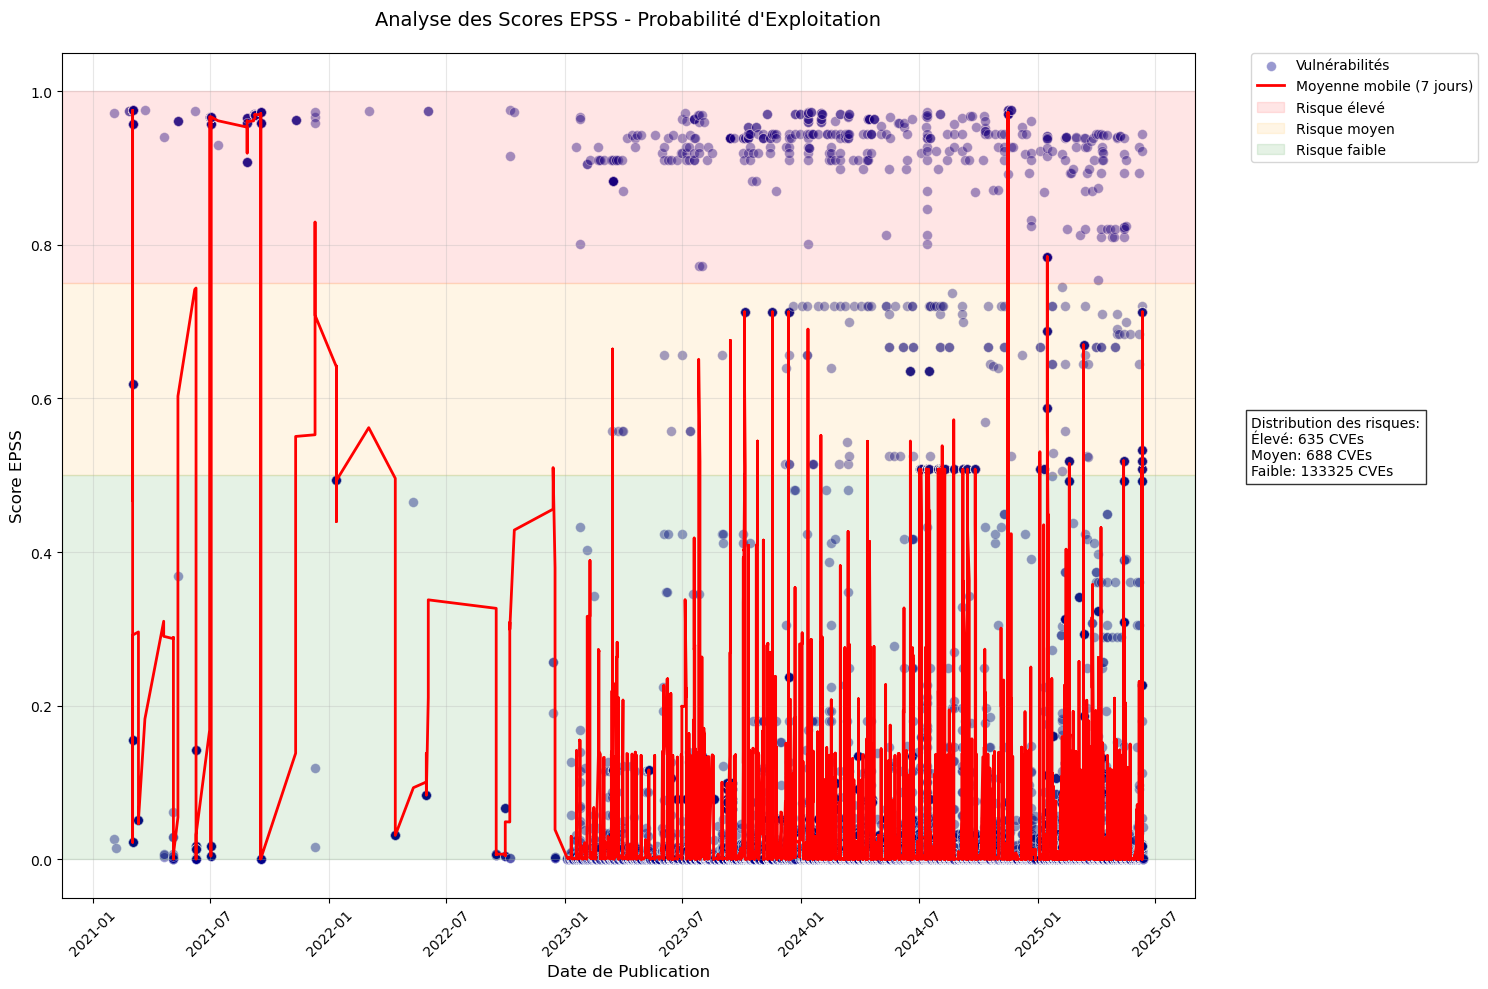


Statistiques des Scores EPSS:
count    134648.000000
mean          0.010345
std           0.077949
min           0.000020
25%           0.000420
50%           0.000450
75%           0.000800
max           0.975150
Name: EPSS_score, dtype: float64


In [37]:
# 3. Courbe des scores EPSS

df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df_sorted = df.sort_values('Date_publication')

# Create main visualization
plt.figure(figsize=(15, 10))

# 1. Scatter plot of vulnerabilities
sns.scatterplot(data=df_sorted, 
                x='Date_publication',
                y='EPSS_score',
                alpha=0.4,
                color='darkblue',
                s=50,
                label='Vuln√©rabilit√©s')

# 2. Add moving average (7 days)
df_sorted['MA7'] = df_sorted['EPSS_score'].rolling(window=7).mean()
plt.plot(df_sorted['Date_publication'], 
         df_sorted['MA7'], 
         color='red', 
         linewidth=2, 
         label='Moyenne mobile (7 jours)')

# 3. Add risk zones
plt.axhspan(0.75, 1.0, color='red', alpha=0.1, label='Risque √©lev√©')
plt.axhspan(0.5, 0.75, color='orange', alpha=0.1, label='Risque moyen')
plt.axhspan(0, 0.5, color='green', alpha=0.1, label='Risque faible')

# 4. Customize appearance
plt.title('Analyse des Scores EPSS - Probabilit√© d\'Exploitation', fontsize=14, pad=20)
plt.xlabel('Date de Publication', fontsize=12)
plt.ylabel('Score EPSS', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 5. Add informative legend
plt.legend(bbox_to_anchor=(1.05, 1), 
          loc='upper left', 
          borderaxespad=0.)

# 6. Add risk statistics annotations
high_risk = len(df[df['EPSS_score'] > 0.75])
medium_risk = len(df[(df['EPSS_score'] > 0.5) & (df['EPSS_score'] <= 0.75)])
low_risk = len(df[df['EPSS_score'] <= 0.5])

stats_text = f'Distribution des risques:\n√âlev√©: {high_risk} CVEs\nMoyen: {medium_risk} CVEs\nFaible: {low_risk} CVEs'
plt.text(1.05, 0.5, stats_text, 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nStatistiques des Scores EPSS:")
print(df['EPSS_score'].describe())

C:\Users\anael\AppData\Local\Temp\ipykernel_32916\3890083656.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_editeurs.values, y=top_editeurs.index, palette="Reds_r")


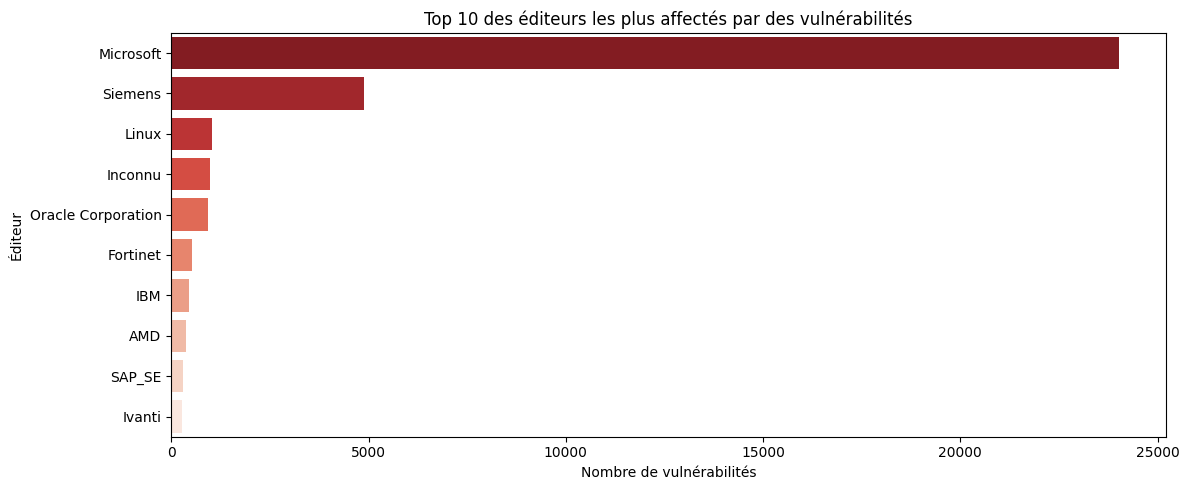

C:\Users\anael\AppData\Local\Temp\ipykernel_32916\3890083656.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_produits.values, y=top_produits.index, palette="Blues_r")


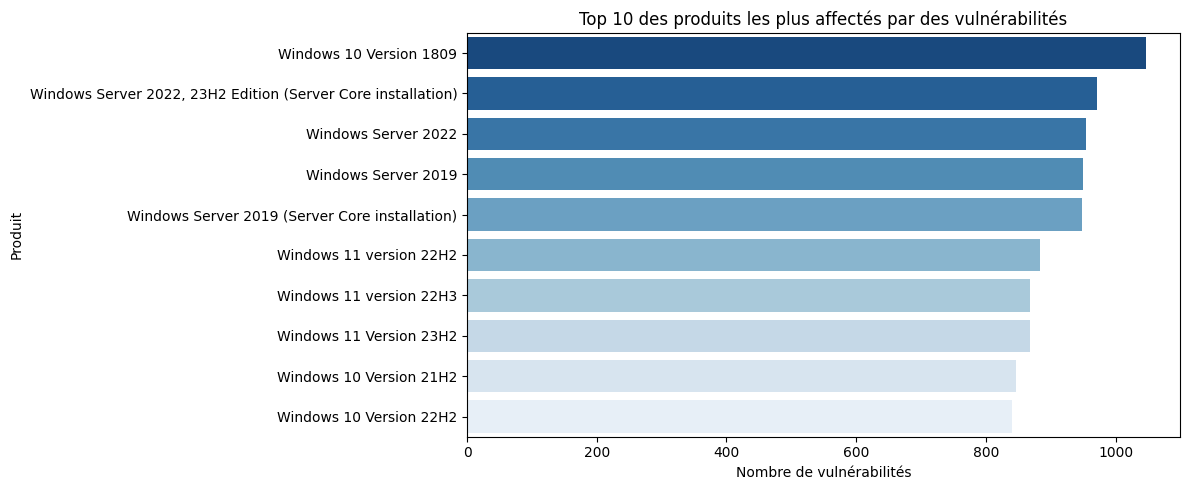

In [41]:
# Graphique 4.1 : √âditeurs les plus vuln√©rables

# Ce graphique permet de rep√©rer les √©diteurs dont les produits sont les plus vuln√©rables dans la base analys√©e
# Cela peut permettre d‚Äôidentifier les √©diteurs les plus expos√©s aux failles de s√©curit√© et de cibler les efforts de veille et de correction sur les fournisseurs concern√©s

top_editeurs = df["Editeur"].value_counts().dropna().head(10) #top 10 des √©diteurs les plus affect√©s
plt.figure(figsize=(12, 5))
sns.barplot(x=top_editeurs.values, y=top_editeurs.index, palette="Reds_r")
plt.title("Top 10 des √©diteurs les plus affect√©s par des vuln√©rabilit√©s")
plt.xlabel("Nombre de vuln√©rabilit√©s")
plt.ylabel("√âditeur")
plt.tight_layout()
plt.show()



# Graphique 4.2 : Produits les plus vuln√©rables

# Ce graphique cible les produits sp√©cifiques les plus vuln√©rables
# Il peut √™tre essentiel pour prioriser les mises √† jour et correctifs sur les logiciels les plus √† risque, cibler les environnements critiques √† s√©curiser (postes, serveurs, OS...),mais aussi identifier les versions de produits qui n√©cessitent un suivi renforc√©

top_produits = df["Produit"].value_counts().dropna().head(10) #top 10 des produits les plus affect√©s
plt.figure(figsize=(12, 5))
sns.barplot(x=top_produits.values, y=top_produits.index, palette="Blues_r")
plt.title("Top 10 des produits les plus affect√©s par des vuln√©rabilit√©s")
plt.xlabel("Nombre de vuln√©rabilit√©s")
plt.ylabel("Produit")
plt.tight_layout()
plt.show()

Le premier graphique pr√©sente les 10 √©diteurs ayant le plus de vuln√©rabilit√©s recens√©es. On observe une nette domination de Microsoft, avec un nombre de vuln√©rabilit√©s tr√®s largement sup√©rieur aux autres (plus de 24 000). Cela peut s'expliquer par :
- la popularit√© et l‚Äôomnipr√©sence de ses syst√®mes (Windows, Office, ...)
- la surface d‚Äôattaque importante li√©e √† ses nombreux produits d√©ploy√©s √† grande √©chelle

En 2e position, on observe Siemens, un acteur majeur dans le domaine de l‚Äôindustrie et des syst√®mes embarqu√©s, souvent cibl√© en cybers√©curit√© industrielle

D‚Äôautres acteurs comme Linux, Oracle, Fortinet, ou IBM figurent √©galement dans le top, repr√©sentant des produits critiques dans les syst√®mes d‚Äôexploitation, les bases de donn√©es, ou la s√©curit√© r√©seau.

La cat√©gorie "Inconnu" montre un manque de qualit√© dans certains enregistrements de donn√©es

Ce graphique est utile pour les √©quipes de cybers√©curit√© afin de prioriser les audits et les actions de surveillance sur les √©diteurs les plus concern√©s, notamment si leurs produits sont utilis√©s dans l‚Äôorganisation.



Le deuxi√®me graphique pr√©sente les produits individuels les plus vuln√©rables. On constate que :

- Les 10 produits appartiennent tous √† la famille Windows (Windows 10, 11, Server), ce qui corrobore la position dominante de Microsoft dans le graphique pr√©c√©dent

- En t√™te, on trouve :
    - Windows 10 version 1809, qui semble particuli√®rement expos√©e
    - Suivie de plusieurs versions de Windows Server 2019 et 2022, y compris les variantes Server Core installation

- Windows 11 appara√Æt aussi plusieurs fois, montrant que m√™me les versions r√©centes ne sont pas √©pargn√©es.


Ce graphique permet aux √©quipes IT de cibler les versions de Windows les plus √† risque, prioriser les patchs de s√©curit√© et les mises √† jour sur les syst√®mes les plus expos√©s et mieux g√©rer l‚Äôobsolescence de certaines versions (comme 1809, qui n‚Äôest plus support√©e).


Les deux graphiques confirment donc que la surface d‚Äôattaque la plus critique concerne les produits Microsoft, en particulier les syst√®mes d‚Äôexploitation Windows, qu‚Äôils soient client ou serveur.
Cela refl√®te une exposition √©lev√©e due √† leur usage massif, combin√©e √† une recherche active de failles par les chercheurs et les attaquants.

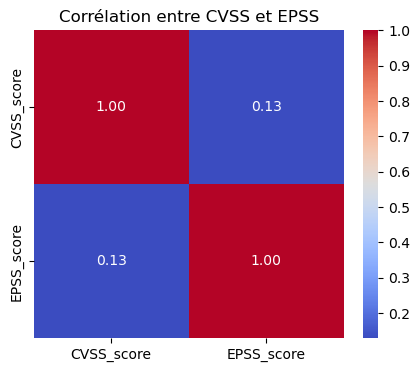

In [41]:
# Heatmap de corr√©lation CVSS / EPSS
plt.figure(figsize=(5,4))
sns.heatmap(df[['CVSS_score', 'EPSS_score']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corr√©lation entre CVSS et EPSS")
plt.show()

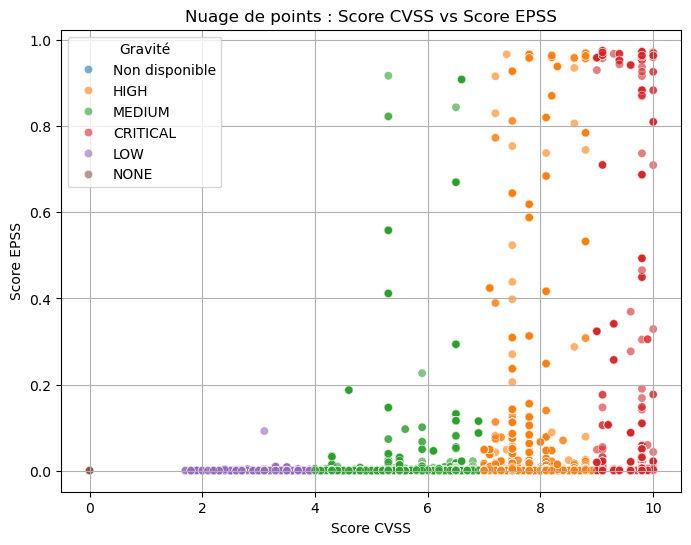

In [43]:
# Nuage de points CVSS vs EPSS
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='CVSS_score', y='EPSS_score', hue='Base_Severity', alpha=0.6)
plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.legend(title='Gravit√©')
plt.show()

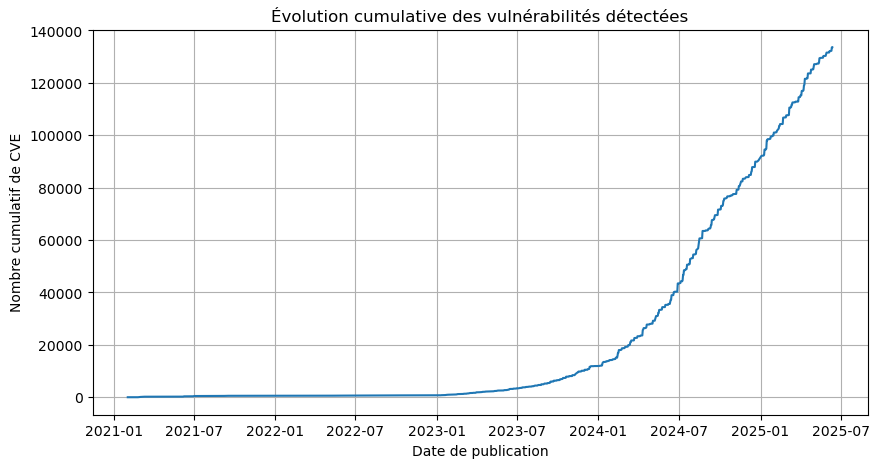

In [45]:
# Courbe cumulative des vuln√©rabilit√©s dans le temps
plt.figure(figsize=(10,5))
df['Date_publication'].dropna().dt.date.value_counts().sort_index().cumsum().plot()
plt.title("√âvolution cumulative des vuln√©rabilit√©s d√©tect√©es")
plt.xlabel("Date de publication")
plt.ylabel("Nombre cumulatif de CVE")
plt.grid(True)
plt.show()

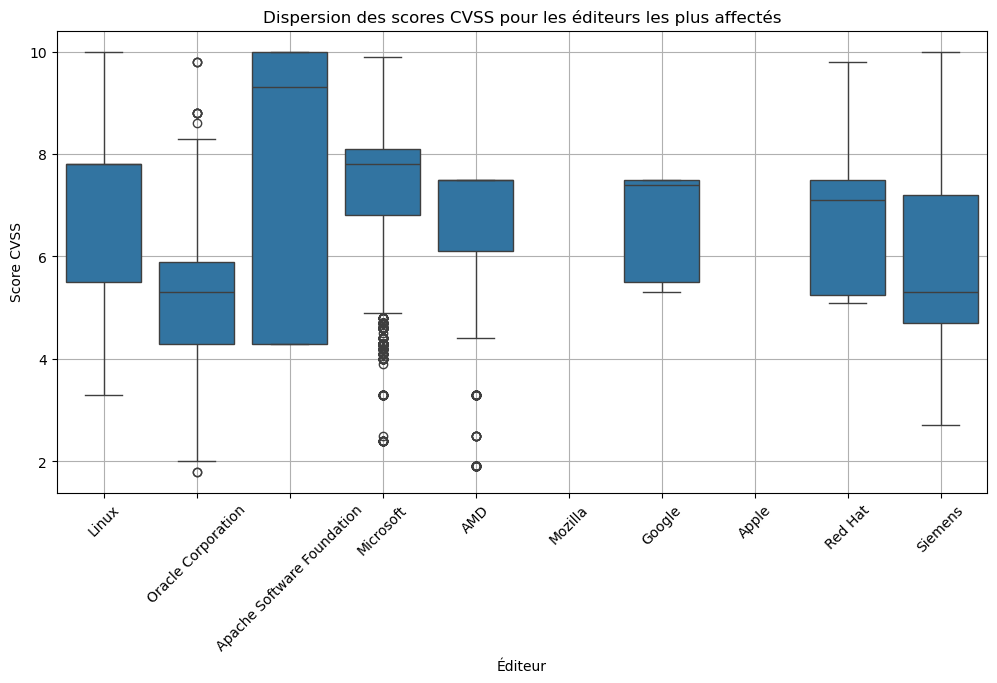

In [47]:
# Boxplot CVSS par √©diteur (top 10)
top_editeurs = df['Editeur'].value_counts().head(10).index
df_top = df[df['Editeur'].isin(top_editeurs)]
plt.figure(figsize=(12,6))
sns.boxplot(data=df_top, x='Editeur', y='CVSS_score')
plt.title("Dispersion des scores CVSS pour les √©diteurs les plus affect√©s")
plt.xlabel("√âditeur")
plt.ylabel("Score CVSS")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

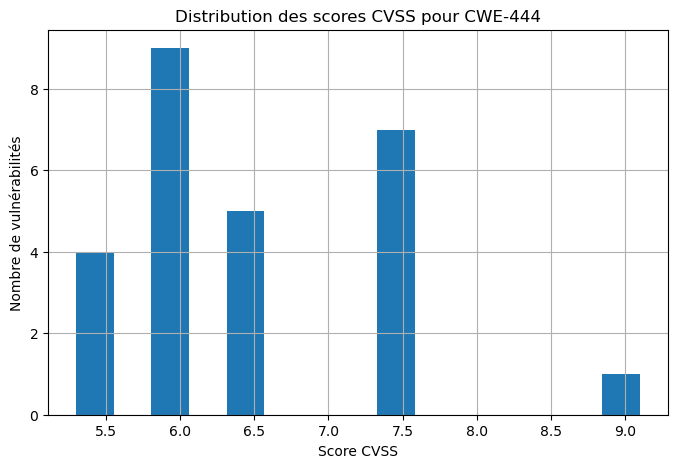

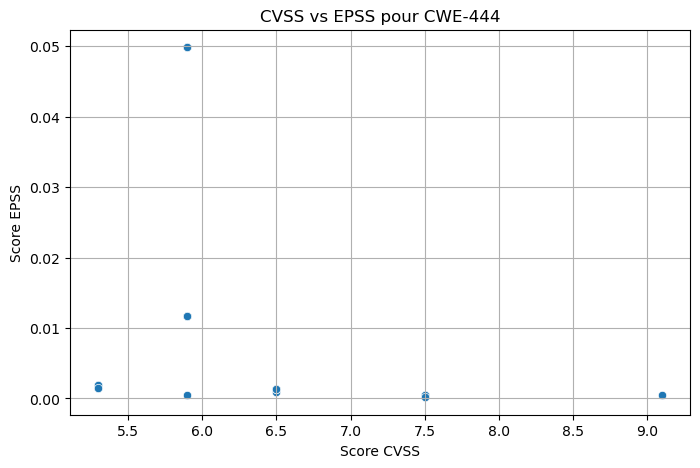

In [49]:
# Visualisation sp√©cifique d'un CWE donn√© 
selected_cwe = "CWE-444"
df_cwe = df[df['CWE'] == selected_cwe]
plt.figure(figsize=(8,5))
df_cwe['CVSS_score'].hist(bins=15)
plt.title(f"Distribution des scores CVSS pour {selected_cwe}")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vuln√©rabilit√©s")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_cwe, x='CVSS_score', y='EPSS_score')
plt.title(f"CVSS vs EPSS pour {selected_cwe}")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.show()

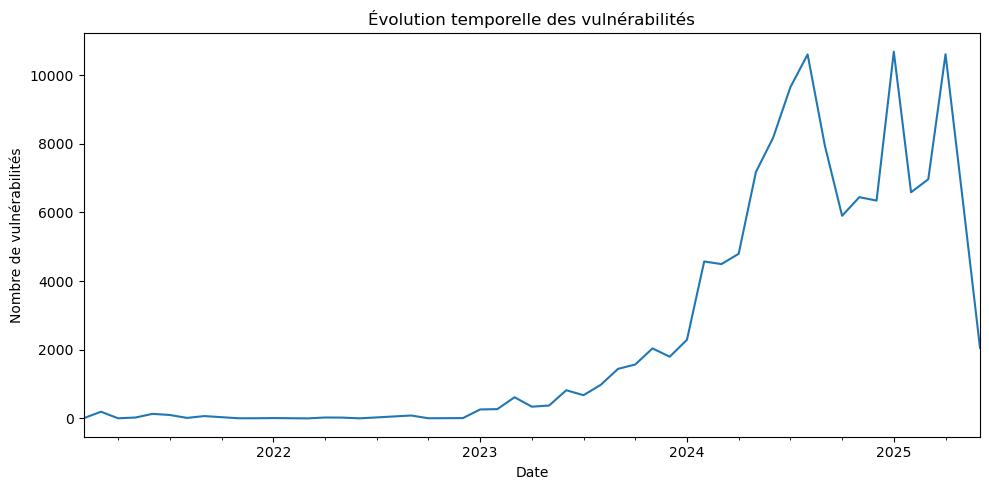

In [51]:
# Evolution temporelle du nombre de vuln\u00e9rabilit\u00e9s
plt.figure(figsize=(10,5))
df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df.groupby(df['Date_publication'].dt.to_period('M')).size().plot()
plt.title("\u00c9volution temporelle des vuln\u00e9rabilit\u00e9s")
plt.xlabel("Date")
plt.ylabel("Nombre de vuln\u00e9rabilit\u00e9s")
plt.tight_layout()
plt.show()

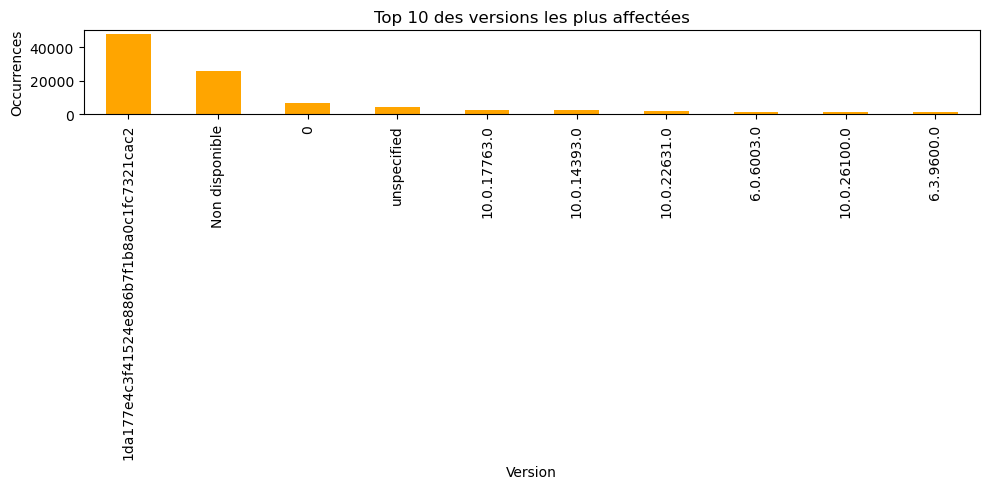

In [53]:
# Versions les plus fr√©quemment touch√©es
plt.figure(figsize=(10,5))
versions = df['Versions_affectees'].dropna().str.split(', ')
flat_versions = [v.strip() for sublist in versions for v in sublist if v.strip() != ""]
pd.Series(flat_versions).value_counts().head(10).plot(kind='bar', color='orange')
plt.title("Top 10 des versions les plus affect\u00e9es")
plt.xlabel("Version")
plt.ylabel("Occurrences")
plt.tight_layout()
plt.show()

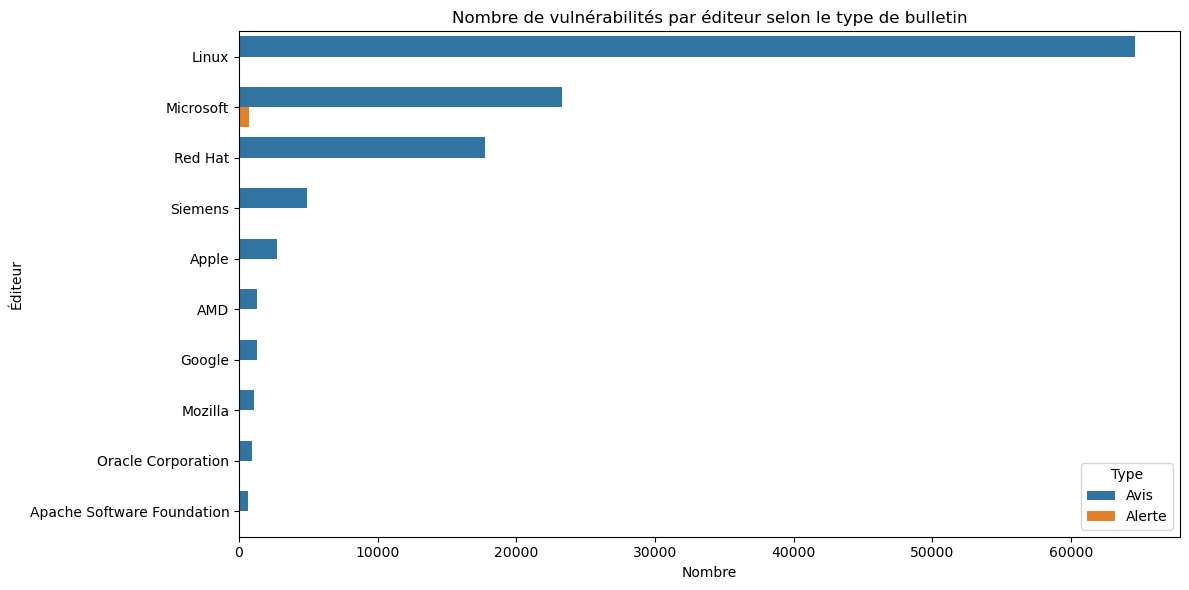

In [55]:
# Nombre de vuln√©rabilit√©es par √©diteur et type de bulletin
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='Editeur', hue='Type', order=df['Editeur'].value_counts().head(10).index)
plt.title("Nombre de vuln\u00e9rabilit\u00e9s par \u00e9diteur selon le type de bulletin")
plt.xlabel("Nombre")
plt.ylabel("\u00c9diteur")
plt.tight_layout()
plt.show()

C:\Users\anael\AppData\Local\Temp\ipykernel_20980\1696579044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CVSS_score'] = df_filtered['CVSS_score'].astype(float)


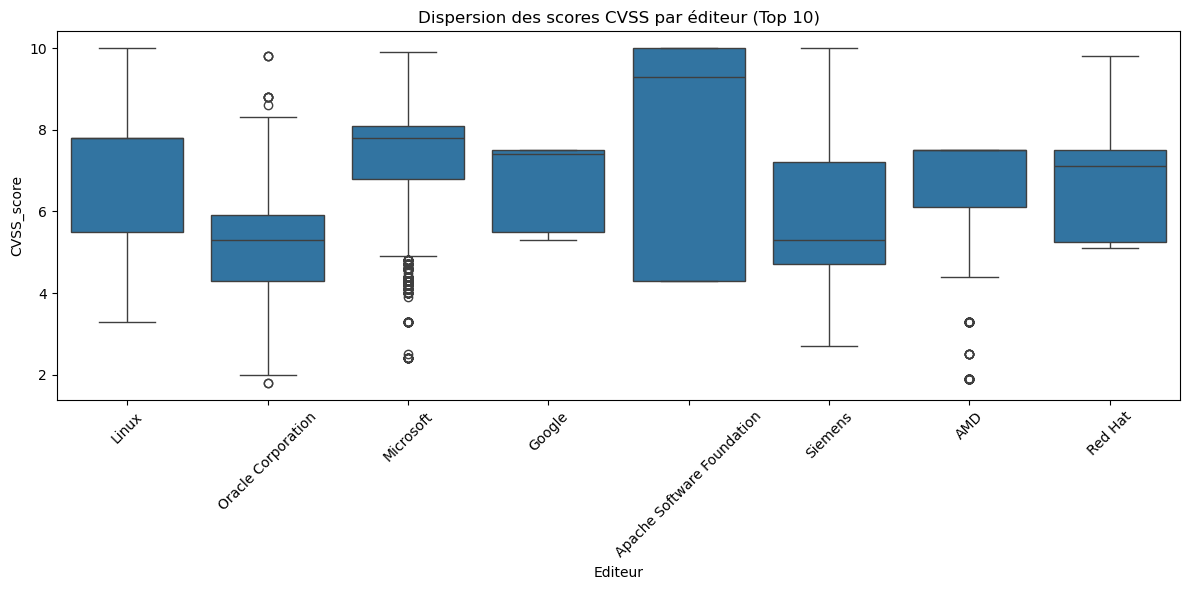

In [57]:
# Dispersion des scores CVSS pour les √©diteurs les plus affect√©es
top_editors = df['Editeur'].value_counts().head(10).index
df_filtered = df[df['Editeur'].isin(top_editors) & df['CVSS_score'].notna()]
df_filtered['CVSS_score'] = df_filtered['CVSS_score'].astype(float)
plt.figure(figsize=(12,6))
sns.boxplot(data=df_filtered, x='Editeur', y='CVSS_score')
plt.title("Dispersion des scores CVSS par \u00e9diteur (Top 10)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

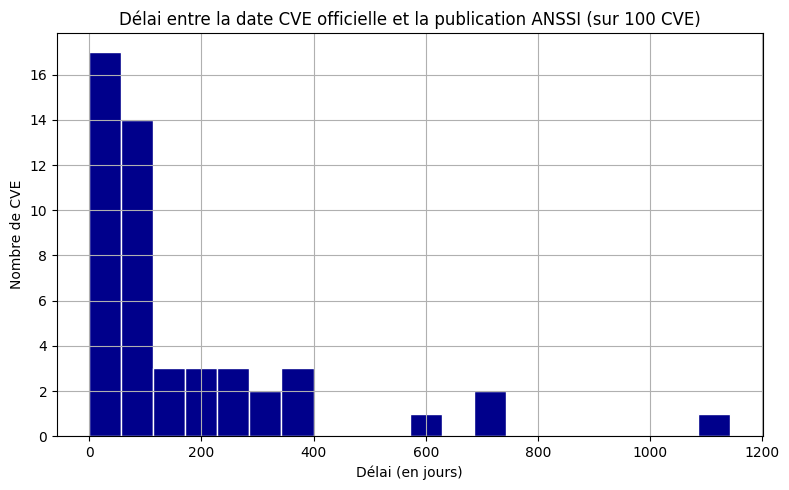

üìä Moyenne du d√©lai : 166.0 jours
üìà M√©diane : 82.0 jours
üìâ Minimum : 0.0 jours
üìà Maximum : 1143.0 jours


In [3]:
import pandas as pd
import requests

# Charger les donn√©es ANSSI
df = pd.read_csv("DataFrame.csv")
df = df.dropna(subset=["CVE_ID", "Date_publication"])

# Forcer les dates ANSSI √† √™tre des datetime sans fuseau horaire
df["Date_publication"] = pd.to_datetime(df["Date_publication"], errors="coerce").dt.tz_localize(None)

# Fonction pour r√©cup√©rer la date officielle de la CVE depuis l'API MITRE
def get_cve_date(cve_id):
    try:
        url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data.get("cveMetadata", {}).get("datePublished")
    except Exception as e:
        print(f"‚ö†Ô∏è Erreur r√©cup√©ration date pour {cve_id}: {e}")
        return None

# S√©lectionner un √©chantillon pour test (√©viter surcharge API)
sample = df.drop_duplicates(subset=["CVE_ID"]).head(100).copy()

# Obtenir les dates CVE
sample["Date_CVE"] = sample["CVE_ID"].apply(get_cve_date)
sample["Date_CVE"] = pd.to_datetime(sample["Date_CVE"], errors="coerce").dt.tz_localize(None)

# Calculer le d√©lai en jours
sample["Delai_jours"] = (sample["Date_publication"] - sample["Date_CVE"]).dt.days
sample = sample.dropna(subset=["Delai_jours"])
sample = sample[sample["Delai_jours"] >= 0]

# Afficher l'histogramme des d√©lais
plt.figure(figsize=(8,5))
sample["Delai_jours"].hist(bins=20, color="darkblue", edgecolor="white")
plt.title("D√©lai entre la date CVE officielle et la publication ANSSI (sur 100 CVE)")
plt.xlabel("D√©lai (en jours)")
plt.ylabel("Nombre de CVE")
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistiques
print("üìä Moyenne du d√©lai :", round(sample["Delai_jours"].mean(), 2), "jours")
print("üìà M√©diane :", sample["Delai_jours"].median(), "jours")
print("üìâ Minimum :", sample["Delai_jours"].min(), "jours")
print("üìà Maximum :", sample["Delai_jours"].max(), "jours")

C:\Users\anael\AppData\Local\Temp\ipykernel_20980\2003815741.py:20: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

C:\Users\anael\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


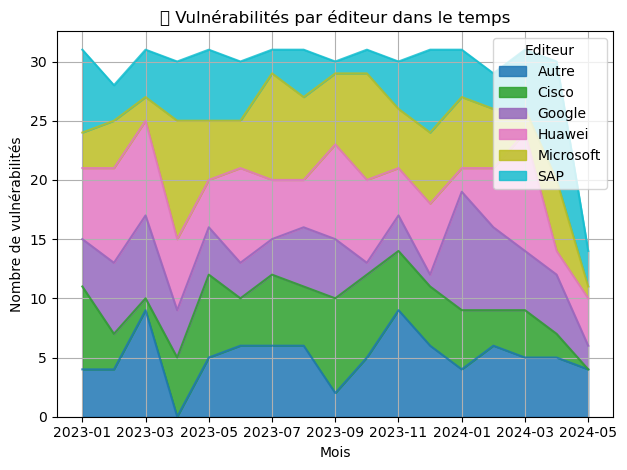

C:\Users\anael\AppData\Local\Temp\ipykernel_20980\2003815741.py:44: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\anael\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


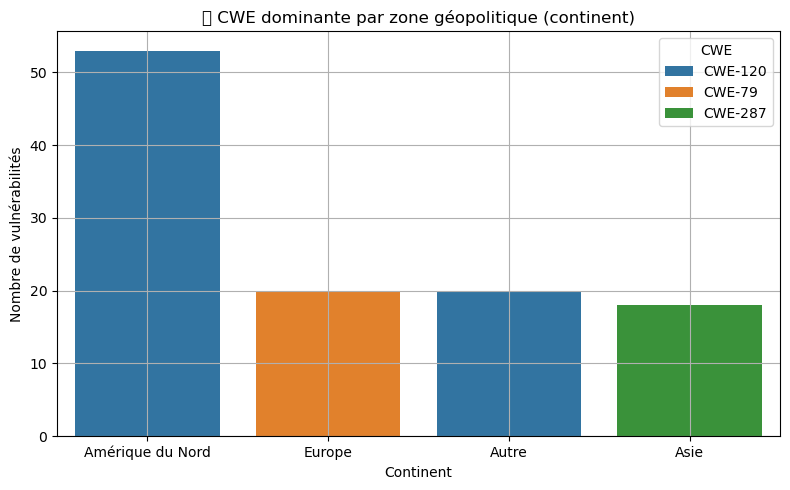

In [61]:
# Donn√©es fictives r√©alistes
np.random.seed(42)
n = 500
df = pd.DataFrame({
    "Date_publication": pd.date_range("2023-01-01", periods=n, freq="D"),
    "Editeur": np.random.choice(["Microsoft", "Google", "Cisco", "Huawei", "SAP", "Autre"], size=n),
    "CWE": np.random.choice(["CWE-79", "CWE-89", "CWE-287", "CWE-20", "CWE-120", "Non class√©"], size=n)
})

# üß± Stacked Timeline
df["Mois"] = df["Date_publication"].dt.to_period("M").astype(str)
timeline = df.groupby(["Mois", "Editeur"]).size().unstack(fill_value=0)

plt.figure(figsize=(12,6))
timeline.plot(kind="area", stacked=True, colormap="tab10", alpha=0.85)
plt.title("üß± Vuln√©rabilit√©s par √©diteur dans le temps")
plt.ylabel("Nombre de vuln√©rabilit√©s")
plt.xlabel("Mois")
plt.grid(True)
plt.tight_layout()
plt.show()

# üìç Mapping √©diteur ‚Üí continent
editeur_continent = {
    "Microsoft": "Am√©rique du Nord",
    "Google": "Am√©rique du Nord",
    "Cisco": "Am√©rique du Nord",
    "Huawei": "Asie",
    "SAP": "Europe",
    "Autre": "Autre"
}
df["Continent"] = df["Editeur"].map(editeur_continent)

# CWE dominante par continent
cwe_counts = df.groupby(["Continent", "CWE"]).size().reset_index(name="count")
top_cwe_by_continent = cwe_counts.sort_values("count", ascending=False).drop_duplicates("Continent")

plt.figure(figsize=(8,5))
sns.barplot(data=top_cwe_by_continent, x="Continent", y="count", hue="CWE")
plt.title("üìç CWE dominante par zone g√©opolitique (continent)")
plt.ylabel("Nombre de vuln√©rabilit√©s")
plt.xlabel("Continent")
plt.grid(True)
plt.tight_layout()
plt.show()